In [2]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import cv2
from tqdm import tqdm
import sklearn.metrics
import skimage.io
from sklearn.cluster import KMeans

from scipy import ndimage as ndi
from skimage.segmentation import watershed, felzenszwalb
from skimage.filters import sobel
from skimage.filters import rank
from skimage.morphology import disk
import sklearn.metrics

from utils import get_data, plot_slice_seg, rand_index_dataset, prediction_to_df, df_get_ith_image

In [5]:
X_train, X_test, y_train = get_data()

ValueError: invalid literal for int() with base 10: "' filemode='drwxr-xr-x'>"

In [ ]:
class Block(nn.Module):
    def __init__(self, in_filters, out_filters):
        
        super(Block, self).__init__()
            
        self.conv1 = nn.Conv2d(in_filters, out_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_filters, out_filters, kernel_size=3, padding=1)
    
        self.batchnorm1 = nn.BatchNorm2d(out_filters)
        self.batchnorm2 = nn.BatchNorm2d(out_filters)
        
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)

    def forward(self, x):
        
        x = self.batchnorm1(self.conv1(x)).clamp(0)
        x = self.relu1(x)
        x = self.dropout1(x)
 
        x = self.batchnorm2(self.conv2(x)).clamp(0)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        return x

In [ ]:
class Unet(nn.Module):

    def __init__(self, k, in_channels, filters):

        super(Unet, self).__init__()
        
        self.enc1 = Block(in_channels, filters)
        self.enc2 = Block(filters, 2*filters)
        self.enc3 = Block(2*filters, 4*filters)
        self.enc4 = Block(4*filters, 8*filters)   
        self.enc5 = Block(8*filters, 16*filters) #minimal dimension space
        
# ---- We define the transpose convolution, that does up pooling 2x2 (inverse of maxpooling)

        self.up1 = nn.ConvTranspose2d(16*filters, 8*filters, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec1 = Block(16*filters, 8*filters)
        self.up2 = nn.ConvTranspose2d(8*filters, 4*filters, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec2 = Block(8*filters, 4*filters)
        self.up3 = nn.ConvTranspose2d(4*filters, 2*filters, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec3 = Block(4*filters, 2*filters)
        self.up4 = nn.ConvTranspose2d(2*filters, filters, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec4 = Block(2*filters, filters)
        
        self.output = nn.Conv2d(filters, k, kernel_size=(1, 1))

    def forward(self, x):

# ---- We define the down sampling phase : block/max pooling

        enc1 = self.enc1(x)
        maxpool1 = F.max_pool2d(enc1, (2, 2))   
        enc2 = self.enc2(maxpool1)
        maxpool2 = F.max_pool2d(enc2, (2, 2))    
        enc3 = self.enc3(maxpool2)
        maxpool3 = F.max_pool2d(enc3, (2, 2))    
        enc4 = self.enc4(maxpool3)
        maxpool4 = F.max_pool2d(enc4, (2, 2))      
        enc5=self.enc5(maxpool4)   
        
# ---- We define the up sampling phase : transposed convolution(= up pooling)/block
# ---- We define the skip connections

        up1 = torch.cat([enc4, self.up1(enc5)], 1) # skip connection : concatenate previous layer output + enc4 output
        dec1 = self.dec1(up1)   
        up2 = torch.cat([enc3, self.up2(dec1)], 1)
        dec2 = self.dec2(up2)   
        up3 = torch.cat([enc2, self.up3(dec2)], 1)
        dec3 = self.dec3(up3)  
        up4 = torch.cat([enc1, self.up4(dec3)], 1)
        dec4 = self.dec4(up4)       
        output = self.output(dec4)
            
        return output

In [ ]:
Unet_model = Unet(k=10, in_channels=1, filters=64)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Unet_model.parameters(), lr=1e-5, weight_decay=1e-8, foreach=True)

In [ ]:
summary(Unet_model, (1, 512, 512), 64)

RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 134217728 bytes.

In [1]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)


In [2]:
dls = ImageDataLoaders.from_name_re(path=path, bs=64,
    fnames = get_image_files(path/"images"), pat = r'/([^/]+)_\d+.jpg$',
    item_tfms=RandomResizedCrop(450, min_scale=0.75), 
    batch_tfms=[*aug_transforms(size=224, max_warp=0.), Normalize.from_stats(*imagenet_stats)])


AssertionError: Failed to find "re.compile('/([^/]+)_\\d+.jpg$')" in "Bombay_109.jpg"

In [ ]:
dls.show_batch()

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)


In [ ]:
learn.fit_one_cycle(4)

In [ ]:
learn.show_results()

In [10]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import torch
from torch import Tensor
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import torch.nn.functional as F
import cv2

from torch.utils.data import DataLoader
from torchvision import transforms, utils
from torch.utils.data import Dataset, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Grayscale

In [3]:
from skimage.segmentation import clear_border
from skimage import measure
from skimage.measure import label, regionprops_table
from scipy import ndimage as ndi
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom
import plotly.graph_objects as go


In [5]:
data_dir = Path("C:/Users/arist/challenge_ens/Datasets/")
labels_train = pd.read_csv(data_dir  / "Y_train.csv", index_col=0).T

def load_dataset(dataset_dir):
    dataset_list = []
    for image_file in list(sorted(Path(dataset_dir).glob("*.png"), 
                                  key=lambda filename: int(filename.name.rstrip(".png")))):
        dataset_list.append(cv2.imread(str(image_file), cv2.IMREAD_GRAYSCALE))
    return np.stack(dataset_list, axis=0)

data_train = load_dataset(data_dir/"X_train/images")
data_test = load_dataset(data_dir/"X_test/images")

In [23]:
labels_train = pd.read_csv(data_dir  / "Y_train.csv", index_col=0).T

In [30]:
labels_values = labels_train.values.reshape(-1, 512, 512)
labels_train[:200].nunique(axis=1).max()

30

In [7]:
print(type(data_train), data_train.shape)

<class 'numpy.ndarray'> (1000, 512, 512)


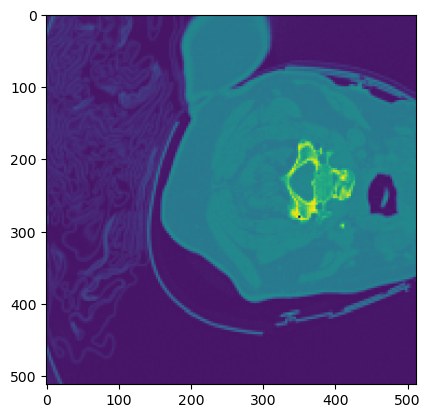

In [19]:
plt.imshow(data_train[652])

In [31]:
#coding=utf-8
from keras.layers.advanced_activations import PReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D, ZeroPadding2D
from keras.layers.core import SpatialDropout2D, Permute, Activation, Reshape
from keras.layers.merge import add, concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.engine.topology import Input
from keras.models import Model

__all__ = ['ENet']

def initial_block(inp, nb_filter=13, nb_row=3, nb_col=3, strides=(2, 2)):
    conv = Conv2D(nb_filter, (nb_row, nb_col), padding='same', strides=strides)(inp)
    max_pool = MaxPooling2D()(inp)
    merged = concatenate([conv, max_pool], axis=3)
    return merged

def bottleneck(inp, output, internal_scale=4, asymmetric=0, dilated=0, downsample=False, dropout_rate=0.1):
    # main branch
    internal = output // internal_scale
    encoder = inp
    # 1x1
    input_stride = 2 if downsample else 1  # the 1st 1x1 projection is replaced with a 2x2 convolution when downsampling
    encoder = Conv2D(internal, (input_stride, input_stride),
                     # padding='same',
                     strides=(input_stride, input_stride), use_bias=False)(encoder)
    # Batch normalization + PReLU
    encoder = BatchNormalization(momentum=0.1)(encoder)  # enet uses momentum of 0.1, keras default is 0.99
    encoder = PReLU(shared_axes=[1, 2])(encoder)

    # conv
    if not asymmetric and not dilated:
        encoder = Conv2D(internal, (3, 3), padding='same')(encoder)
    elif asymmetric:
        encoder = Conv2D(internal, (1, asymmetric), padding='same', use_bias=False)(encoder)
        encoder = Conv2D(internal, (asymmetric, 1), padding='same')(encoder)
    elif dilated:
        encoder = Conv2D(internal, (3, 3), dilation_rate=(dilated, dilated), padding='same')(encoder)
    else:
        raise (Exception('You shouldn\'t be here'))

    encoder = BatchNormalization(momentum=0.1)(encoder)  # enet uses momentum of 0.1, keras default is 0.99
    encoder = PReLU(shared_axes=[1, 2])(encoder)

    # 1x1
    encoder = Conv2D(output, (1, 1), use_bias=False)(encoder)

    encoder = BatchNormalization(momentum=0.1)(encoder)  # enet uses momentum of 0.1, keras default is 0.99
    encoder = SpatialDropout2D(dropout_rate)(encoder)

    other = inp
    # other branch
    if downsample:
        other = MaxPooling2D()(other)

        other = Permute((1, 3, 2))(other)
        pad_feature_maps = output - inp.get_shape().as_list()[3]
        tb_pad = (0, 0)
        lr_pad = (0, pad_feature_maps)
        other = ZeroPadding2D(padding=(tb_pad, lr_pad))(other)
        other = Permute((1, 3, 2))(other)

    encoder = add([encoder, other])
    encoder = PReLU(shared_axes=[1, 2])(encoder)

    return encoder

def en_build(inp, dropout_rate=0.01):
    enet = initial_block(inp)
    enet = BatchNormalization(momentum=0.1)(enet)  # enet_unpooling uses momentum of 0.1, keras default is 0.99
    enet = PReLU(shared_axes=[1, 2])(enet)
    enet = bottleneck(enet, 64, downsample=True, dropout_rate=dropout_rate)  # bottleneck 1.0
    for _ in range(4):
        enet = bottleneck(enet, 64, dropout_rate=dropout_rate)  # bottleneck 1.i

    enet = bottleneck(enet, 128, downsample=True)  # bottleneck 2.0
    # bottleneck 2.x and 3.x
    for _ in range(2):
        enet = bottleneck(enet, 128)  # bottleneck 2.1
        enet = bottleneck(enet, 128, dilated=2)  # bottleneck 2.2
        enet = bottleneck(enet, 128, asymmetric=5)  # bottleneck 2.3
        enet = bottleneck(enet, 128, dilated=4)  # bottleneck 2.4
        enet = bottleneck(enet, 128)  # bottleneck 2.5
        enet = bottleneck(enet, 128, dilated=8)  # bottleneck 2.6
        enet = bottleneck(enet, 128, asymmetric=5)  # bottleneck 2.7
        enet = bottleneck(enet, 128, dilated=16)  # bottleneck 2.8

    return enet

# decoder
def de_bottleneck(encoder, output, upsample=False, reverse_module=False):
    internal = output // 4

    x = Conv2D(internal, (1, 1), use_bias=False)(encoder)
    x = BatchNormalization(momentum=0.1)(x)
    x = Activation('relu')(x)
    if not upsample:
        x = Conv2D(internal, (3, 3), padding='same', use_bias=True)(x)
    else:
        x = Conv2DTranspose(filters=internal, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization(momentum=0.1)(x)
    x = Activation('relu')(x)

    x = Conv2D(output, (1, 1), padding='same', use_bias=False)(x)

    other = encoder
    if encoder.get_shape()[-1] != output or upsample:
        other = Conv2D(output, (1, 1), padding='same', use_bias=False)(other)
        other = BatchNormalization(momentum=0.1)(other)
        if upsample and reverse_module is not False:
            other = UpSampling2D(size=(2, 2))(other)

    if upsample and reverse_module is False:
        decoder = x
    else:
        x = BatchNormalization(momentum=0.1)(x)
        decoder = add([x, other])
        decoder = Activation('relu')(decoder)

    return decoder

def de_build(encoder, nc):
    enet = de_bottleneck(encoder, 64, upsample=True, reverse_module=True)  # bottleneck 4.0
    enet = de_bottleneck(enet, 64)  # bottleneck 4.1
    enet = de_bottleneck(enet, 64)  # bottleneck 4.2
    enet = de_bottleneck(enet, 16, upsample=True, reverse_module=True)  # bottleneck 5.0
    enet = de_bottleneck(enet, 16)  # bottleneck 5.1

    enet = Conv2DTranspose(filters=nc, kernel_size=(2, 2), strides=(2, 2), padding='same')(enet)
    return enet

def ENet(n_classes, input_height=256, input_width=256):
    assert input_height % 32 == 0
    assert input_width % 32 == 0
    img_input = Input(shape=(input_height, input_width, 3))
    enet = en_build(img_input)
    enet = de_build(enet, n_classes)
    o_shape = Model(img_input, enet).output_shape
    outputHeight = o_shape[1]
    outputWidth = o_shape[2]
    enet = (Reshape((outputHeight*outputWidth, n_classes)))(enet)
    enet = Activation('softmax')(enet)
    model = Model(img_input, enet)
    model.outputWidth = outputWidth
    model.outputHeight = outputHeight

    return model

ModuleNotFoundError: No module named 'keras.layers.advanced_activations'